In [1]:
import argparse
import os
import cv2
import numpy as np
import torch
from PIL import Image
import requests
from torchvision import models
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise, KPCA_CAM
)
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


from torchvision.models.segmentation import deeplabv3_resnet50


In [2]:
device="cuda"

In [3]:
methods = {
    "gradcam": GradCAM,
    "hirescam": HiResCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad,
    "gradcamelementwise": GradCAMElementWise,
    'kpcacam': KPCA_CAM
}

device = "cuda"

class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]


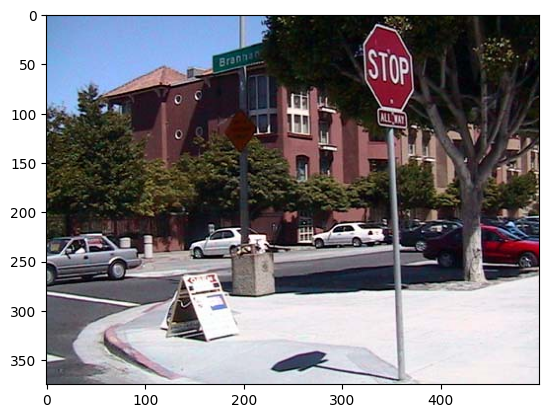

In [4]:

image = np.array(Image.open("experiments/cars.jpg"))
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(image)

In [5]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


# use weights='ResNet50_Weights.DEFAULT' instead of pretrained


original_model = deeplabv3_resnet50(pretrained=True, progress=False)
model = SegmentationModelOutputWrapper(original_model)
model = model.eval()

/media/sd-card-disk/miniconda3/envs/chimcla311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/sd-card-disk/miniconda3/envs/chimcla311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
output = model(input_tensor)

[W1024 15:52:59.342928706 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
output.shape

torch.Size([1, 21, 375, 500])

In [8]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}


In [9]:
car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
img2 = Image.fromarray(both_images)

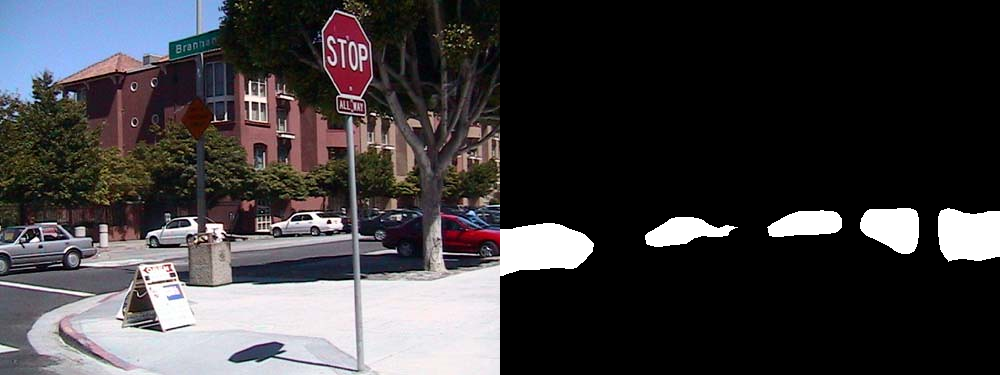

In [10]:
display(img2)

In [11]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


In [16]:
input_tensor.to(device)

tensor([[[[-0.4397, -0.4397, -0.4397,  ..., -2.0152, -1.9980, -1.9980],
          [-0.4054, -0.4397, -0.3883,  ..., -1.9980, -1.9809, -1.9638],
          [-0.3712, -0.3883, -0.3541,  ..., -1.9809, -1.9809, -1.9638],
          ...,
          [-0.6965, -0.6965, -0.7137,  ...,  1.8893,  1.8550,  1.8550],
          [-0.6965, -0.6965, -0.6965,  ...,  1.8893,  1.8550,  1.8550],
          [-0.7308, -0.7308, -0.7308,  ...,  1.8893,  1.8550,  1.8550]],

         [[ 0.5553,  0.5553,  0.5553,  ..., -1.7556, -1.7381, -1.7381],
          [ 0.5378,  0.5553,  0.5553,  ..., -1.7906, -1.7731, -1.7556],
          [ 0.5553,  0.5553,  0.5728,  ..., -1.8081, -1.8081, -1.7906],
          ...,
          [-0.5126, -0.5126, -0.5301,  ...,  2.0434,  2.0084,  2.0084],
          [-0.5126, -0.5126, -0.5126,  ...,  2.0434,  2.0084,  2.0084],
          [-0.5476, -0.5476, -0.5476,  ...,  2.0434,  2.0084,  2.0084]],

         [[ 1.6640,  1.6640,  1.6640,  ..., -1.6824, -1.6650, -1.6650],
          [ 1.6640,  1.6640,  

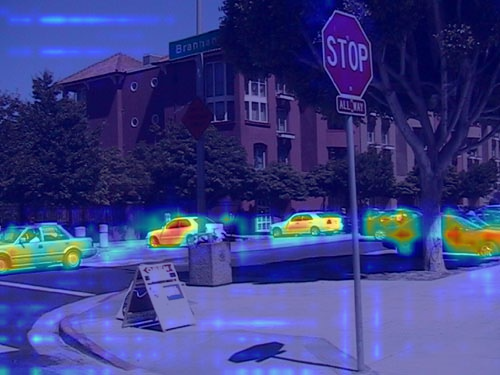

In [17]:
    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor.to(device),
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

In [15]:
GradCAM.__init__??

Signature: GradCAM.__init__(self, model, target_layers, reshape_transform=None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, model, target_layers,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            reshape_transform)
File:      /media/sd-card-disk/miniconda3/envs/chimcla311/lib/python3.11/site-packages/pytorch_grad_cam/grad_cam.py
Type:      function

In [17]:
torch.cuda.is_available()

True